In [2]:
import tensorflow as tf
from utils import Classifier
from utils import *

# Convolutions for Images

## The Cross-Correlation Operation
In a covolutional layer, an input tensor and a kernel tensor are combined to produce an output tensor through a cross-correlation operation.
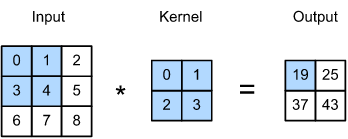

The output size is given by the input size $n_h \times n_w$ minus the size of the convolution kernel $k_h \times k_w$ via $(n_h - k_h + 1) \times (n_w-k_w+1)$

In [3]:
def corr2d(X, K):
    h, w = K.shape
    Y = tf.Variable(tf.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1)))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j].assign(tf.reduce_sum(X[i:i+h, j:j+w] * K))
    return Y

In [5]:
X = tf.constant([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = tf.constant([[0.0, 1.0], [2.0, 3.0]])
X, K, corr2d(X, K)

(<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0., 1.],
        [2., 3.]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
 array([[19., 25.],
        [37., 43.]], dtype=float32)>)

## Convolutional Layers
A convolutional layer cross-correlates the input and kernel and adds a scalar bias to produce an output.
The two parameters of a convolutional layer are the kernel and the scalar bias. 

In [4]:
class Conv2D(tf.keras.layers.Layer):
    """ two-dimensional convolutional layer """

    def __init__(self):
        super().__init__()

    def build(self, kernel_size):
        initializer = tf.random_normal_initializer()
        self.weight = self.add_weight(name='w', shape=kernel_size,
                                      initializer=initializer)
        self.bias = self.add_weight(name='b', shape=(1,),
                                    initializer=initializer)

    def call(self, X):
        return corr2d(X, self.weight) + self.bias

## Object Edge Detection in Images
Detecting the edge of an object in an image by finding the location of the pixel change.

In [5]:
# construct an “image” of 6x8 pixels.
# The middle four columns are black (0) and the rest are white (1).
X = tf.Variable(tf.ones((6, 8)))
X[:, 2:6].assign(tf.zeros(X[:, 2:6].shape))

<tf.Variable 'UnreadVariable' shape=(6, 8) dtype=float32, numpy=
array([[1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.]], dtype=float32)>

In [6]:
# construct a kernel K with a height of 1 and a width of 2
K = tf.constant([[1.0, -1.0]])

When we perform the cross-correlation operation with the input, if the horizontally adjacent elements are the same, the output is 0. Otherwise, the output is non-zero. 

Note that this kernel is special case of a **finite difference operator**. At location $(i,j)$ it computes $x_{i,j}-x_{(i+1),j}$, i.e., it computes the difference between the values of horizontally adjacent pixels. This is a discrete approximation of the first derivative in the horizontal direction.

In [7]:
# We detect 1 for the edge from white to black and -1 for the edge from black to white.
Y = corr2d(X, K)
Y

<tf.Variable 'Variable:0' shape=(6, 7) dtype=float32, numpy=
array([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.]], dtype=float32)>

Apply the kernel to the transposed image. As expected, it vanishes. The kernel K only detects vertical edges.

In [8]:
corr2d(tf.transpose(X), K)

<tf.Variable 'Variable:0' shape=(8, 5) dtype=float32, numpy=
array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

## Learning a Kernel

 let’s see whether we can learn the kernel that generated Y from X by looking at the input–output pairs only. 

In [9]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = tf.keras.layers.Conv2D(1, (1, 2), use_bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, height, width, channel), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = tf.reshape(X, (1, 6, 8, 1))
Y = tf.reshape(Y, (1, 6, 7, 1))
lr = 3e-2

Y_hat = conv2d(X)

for i in range(10):
    with tf.GradientTape(watch_accessed_variables=False) as g:
        g.watch(conv2d.weights[0])
        Y_hat = conv2d(X)
        # Use the squared error to compare Y with the output of the convolutional layer.
        l = (abs(Y_hat - Y)) ** 2
        # Calculate the gradient to update the kernel.
        update = tf.multiply(lr, g.gradient(l, conv2d.weights[0]))
        weights = conv2d.get_weights()
        weights[0] = conv2d.weights[0] - update
        conv2d.set_weights(weights)
        if (i+1) % 2 == 0:
            print(f'epoch {i + 1}, loss {tf.reduce_sum(l):.3f}')

Indeed, the learned kernel tensor is remarkably close to the kernel tensor K we defined earlier.



In [18]:
tf.reshape(conv2d.get_weights()[0], (1, 2))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.9776167, -0.9947706]], dtype=float32)>

# Padding and Stride

As motivation, note that since kernels generally have width and height greater than 
, after applying many successive convolutions, we tend to wind up with outputs that are considerably smaller than our input.

- ***Padding*** is the most popular tool for handling this issue.

- ***Strided convolutions*** help if we find the original input resolution to be unwieldy. 

## Padding
Add extra pixels of filler around the boundary of our input image, thus increasing the effective size of the image. Typically, we set the values of the extra pixels to zero.

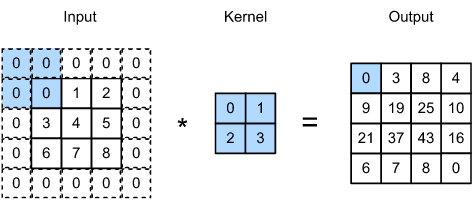

In [41]:
# create a two-dimensional convolutional layer with a height and width of 3 and apply 1 pixel of padding on all sides.
# Given an input with a height and width of 8,
# we find that the height and width of the output is also 8.
def comp_conv2d(conv2d, X):
    X = tf.reshape(X, (1,) + X.shape + (1,))  # -> (1, 8, 8, 1)
    Y = conv2d(X)
    return tf.reshape(Y, Y.shape[1:3])

In [43]:
# 1 row and column is padded on either side, so a total of 2 rows or columns
# are added
conv2d = tf.keras.layers.Conv2D(
    1, kernel_size=3, padding='same')  # 1 output channel
X = tf.random.uniform(shape=(8, 8))
comp_conv2d(conv2d, X).shape

In [32]:
# We use a convolution kernel with height 5 and width 3. The padding on
# either side of the height and width are 2 and 1, respectively
conv2d = tf.keras.layers.Conv2D(1, kernel_size=(5, 3), padding='same')
comp_conv2d(conv2d, X).shape

TensorShape([8, 8])

## Stride
sometimes, either for computational efficiency or because we wish to downsample, we move our window more than one element at a time, skipping the intermediate locations. This is particularly useful if the convolution kernel is large since it captures a large area of the underlying image.

In [45]:
X = tf.cast(tf.random.uniform(
    shape=(8, 8), minval=1, maxval=10), dtype=tf.int32)
X

<tf.Tensor: shape=(8, 8), dtype=int32, numpy=
array([[6, 9, 3, 4, 5, 5, 8, 4],
       [2, 5, 4, 6, 4, 4, 3, 3],
       [2, 1, 2, 8, 5, 6, 5, 2],
       [3, 9, 3, 8, 3, 8, 2, 7],
       [7, 2, 2, 1, 4, 5, 8, 3],
       [4, 3, 4, 4, 8, 5, 5, 3],
       [2, 5, 2, 4, 1, 2, 6, 1],
       [1, 4, 6, 5, 3, 5, 1, 6]], dtype=int32)>

In [47]:
conv2d = tf.keras.layers.Conv2D(1, kernel_size=3,
                                padding='same', strides=2)
X = tf.random.uniform(shape=(8, 8))
comp_conv2d(conv2d, X).shape

TensorShape([4, 4])

In [49]:
conv2d = tf.keras.layers.Conv2D(1, kernel_size=(3, 5),
                                padding='valid', strides=(3, 4))
comp_conv2d(conv2d, X).shape

TensorShape([2, 1])

# Multiple Input and Multiple Output Channels
Channels allow us to combine the best of both worlds: MLPs that allow for significant nonlinearities and convolutions that allow for localized analysis of features. In particular, channels allow the CNN to reason with multiple features, such as edge and shape detectors at the same time. They also offer a practical trade-off between the drastic parameter reduction arising from translation invariance and locality, and the need for expressive and diverse models in computer vision.

Take a deeper look at convolution kernels with multiple input and multiple output channels.

## Multiple Input Channels 
Need to  construct a convolution kernel with the same number of input channels as the input data, so that it can perform cross-correlation with the input data.
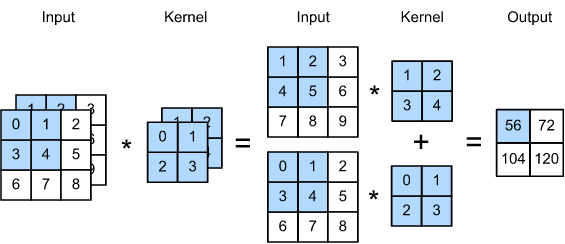

In [60]:
def corr2d_multi_in(X, K):
    # Iterate through the 0th dimension (channel) of K first, then add them up
    return tf.reduce_sum([corr2d(x, k) for x, k in zip(X, K)], axis=0)

In [61]:
X = tf.constant([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
                 [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = tf.constant([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])
print(X.shape, K.shape)

corr2d_multi_in(X, K)

(2, 3, 3) (2, 2, 2)


<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 56.,  72.],
       [104., 120.]], dtype=float32)>

## Multiple Output Channels

In [62]:
#  implement a cross-correlation function to calculate the output of multiple channels
def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are
    # stacked together
    return tf.stack([corr2d_multi_in(X, k) for k in K], axis=0)

In [63]:
# construct a convolution kernel with 3 output channels by
# concatenating the kernel tensor for K with K+1 and K+2.
K = tf.stack((K, K+1, K+2), 0)
print(X.shape, K.shape)

(2, 3, 3) (3, 2, 2, 2)


 Now the output contains 3 channels. The result of the first channel is consistent with the result of the previous input tensor X and the multi-input channel, single-output channel kernel.

In [59]:
corr2d_multi_in_out(X, K)

<tf.Tensor: shape=(3, 2, 2), dtype=float32, numpy=
array([[[ 56.,  72.],
        [104., 120.]],

       [[ 76., 100.],
        [148., 172.]],

       [[ 96., 128.],
        [192., 224.]]], dtype=float32)>

## 1 X 1 Convolutional Layer
1x1 convolution loses the ability of larger convolutional layers to recognize patterns consisting of interactions among adjacent elements in the height and width dimensions. The only computation of the 1x1 convolution occurs on the channel dimension.

Each element in the output is derived from a linear combination of elements at the same position in the input image. You could think of the 
1x1 convolutional layer as constituting a fully connected layer applied at every single pixel location to transform the $c_i$ corresponding input values into $c_v$ output values.

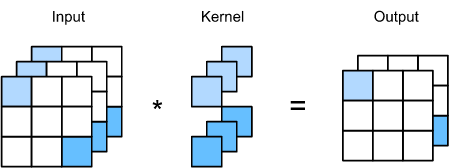

In [64]:
#  implement a 1x1 convolution using a fully connected layer.
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = tf.reshape(X, (c_i, h*w))
    K = tf.reshape(K, (c_o, c_i))
    # Matrix multiplication in the fully connected layer
    Y = tf.matmul(K, X)
    return tf.reshape(Y, (c_o, h, w))

In [78]:
X = tf.cast(tf.reshape(tf.range(27), (3,3,3)), tf.float32)  # c_i, h, w
K = tf.cast(tf.reshape(tf.range(6), (2,3,1,1)), tf.float32) # c_o, c_i, k_h, k_w

In [79]:
Y1 = corr2d_multi_in_out_1x1(X, K)
Y1

<tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
array([[[ 45.,  48.,  51.],
        [ 54.,  57.,  60.],
        [ 63.,  66.,  69.]],

       [[126., 138., 150.],
        [162., 174., 186.],
        [198., 210., 222.]]], dtype=float32)>

In [80]:
Y2 = corr2d_multi_in_out(X, K)
Y2

<tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
array([[[ 45.,  48.,  51.],
        [ 54.,  57.,  60.],
        [ 63.,  66.,  69.]],

       [[126., 138., 150.],
        [162., 174., 186.],
        [198., 210., 222.]]], dtype=float32)>

# Pooling 
 The deeper we go in the network, the larger the receptive field (relative to the input) to which each hidden node is sensitive. Reducing spatial resolution accelerates this process, since the convolution kernels cover a larger effective area.
 
**pooling layers**, which serve the dual purposes of mitigating the sensitivity of convolutional layers to location and of spatially downsampling representations.

## Maximum Pooling and Average Pooling

The pooling layer contains no parameters (there is no kernel). Instead, pooling operators are deterministic, typically calculating either the maximum or the average value of the elements in the pooling window.

In [81]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = tf.Variable(tf.zeros((X.shape[0] - p_h + 1,X.shape[1] - p_h + 1)))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i,j].assign(tf.reduce_max(X[i:i+p_h, j:j+p_w]))
            elif mode == 'avg':
                Y[i,j].assign(tf.reduce_mean(X[i:i+p_h, j:j+p_w]))
    return Y

In [83]:
X = tf.constant([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
print(X)
pool2d(X, pool_size = (2,2), mode='max')

tf.Tensor(
[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]], shape=(3, 3), dtype=float32)


<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[4., 5.],
       [7., 8.]], dtype=float32)>

In [84]:
pool2d(X, pool_size = (2,2), mode='avg')

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

## Padding and Stride

In [105]:
X = tf.reshape(tf.range(16, dtype=tf.float32), (1,4,4,1))
X

<tf.Tensor: shape=(1, 4, 4, 1), dtype=float32, numpy=
array([[[[ 0.],
         [ 1.],
         [ 2.],
         [ 3.]],

        [[ 4.],
         [ 5.],
         [ 6.],
         [ 7.]],

        [[ 8.],
         [ 9.],
         [10.],
         [11.]],

        [[12.],
         [13.],
         [14.],
         [15.]]]], dtype=float32)>

Since pooling aggregates information from an area, deep learning frameworks default to matching **pooling window** sizes and **stride**. For instance, if we use a pooling window of shape (3, 3) we get a stride shape of (3, 3) by default.

In [91]:
pool2d = tf.keras.layers.MaxPool2D(pool_size=[2,2])
pool2d(X)

<tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
array([[[[ 5.],
         [ 7.]],

        [[13.],
         [15.]]]], dtype=float32)>

In [96]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
paddings = tf.constant([[0,0],[1,0],[1,0],[0,0]])
X_padded = tf.pad(X, paddings, 'CONSTANT')
pool2d = tf.keras.layers.MaxPooling2D(pool_size=[3,3], padding='valid',
                                     strides=2)
pool2d(X_padded)

<tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
array([[[[ 5.],
         [ 7.]],

        [[13.],
         [15.]]]], dtype=float32)>

In [100]:
paddings=tf.constant([[0,0],[0,0],[1,1],[0,0]])
X_padded = tf.pad(X, paddings, 'CONSTANT')
pool2d = tf.keras.layers.MaxPool2D(pool_size=[2,3], padding='valid',
                                  strides=(2,3))
pool2d(X_padded)

<tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
array([[[[ 5.],
         [ 7.]],

        [[13.],
         [15.]]]], dtype=float32)>

## Multiple Channels 
When processing multi-channel input data, the pooling layer pools each input channel separately, rather than summing the inputs up over channels as in a convolutional layer. This means that the number of output channels for the pooling layer is the same as the number of input channels.

In [106]:
# Concatenate along `dim=3` due to channels-last syntax
X = tf.concat([X, X+1], axis=3)
X

<tf.Tensor: shape=(1, 4, 4, 2), dtype=float32, numpy=
array([[[[ 0.,  1.],
         [ 1.,  2.],
         [ 2.,  3.],
         [ 3.,  4.]],

        [[ 4.,  5.],
         [ 5.,  6.],
         [ 6.,  7.],
         [ 7.,  8.]],

        [[ 8.,  9.],
         [ 9., 10.],
         [10., 11.],
         [11., 12.]],

        [[12., 13.],
         [13., 14.],
         [14., 15.],
         [15., 16.]]]], dtype=float32)>

In [107]:
paddings = tf.constant([[0,0],[1,0],[1,0],[0,0]])
X_padded = tf.pad(X, paddings, 'CONSTANT')
pool2d = tf.keras.layers.MaxPooling2D(pool_size=[3,3], padding='valid',
                                     strides=2)
pool2d(X_padded)

<tf.Tensor: shape=(1, 2, 2, 2), dtype=float32, numpy=
array([[[[ 5.,  6.],
         [ 7.,  8.]],

        [[13., 14.],
         [15., 16.]]]], dtype=float32)>

# Convolutional Neural Networks (LeNet) 
LeNet (LeNet-5) consists of two parts: 
1. A convolutional encoder consisting of two convolutional layers; 
    - Each convolutional layer uses a 5X5 kernel and a sigmoid activation function.
    - These layers map spatially arranged inputs to a number of two-dimensional feature maps, typically increasing the number of channels. The first convolutional layer has 6 output channels, while the second has 16. 
    - Each 2X2 pooling operation (stride 2) reduces dimensionality by a factor of 4 via spatial downsampling. 
    - The convolutional block emits an output with shape given by (batch size, number of channel, height, width).
2. A dense block consisting of three fully connected layers;
    - Flatten each example in the minibatch, in order to pass output from the convolutional block to the dense block
    - Three fully connected layers, with 120, 84, and 10 outputs, respectively. 
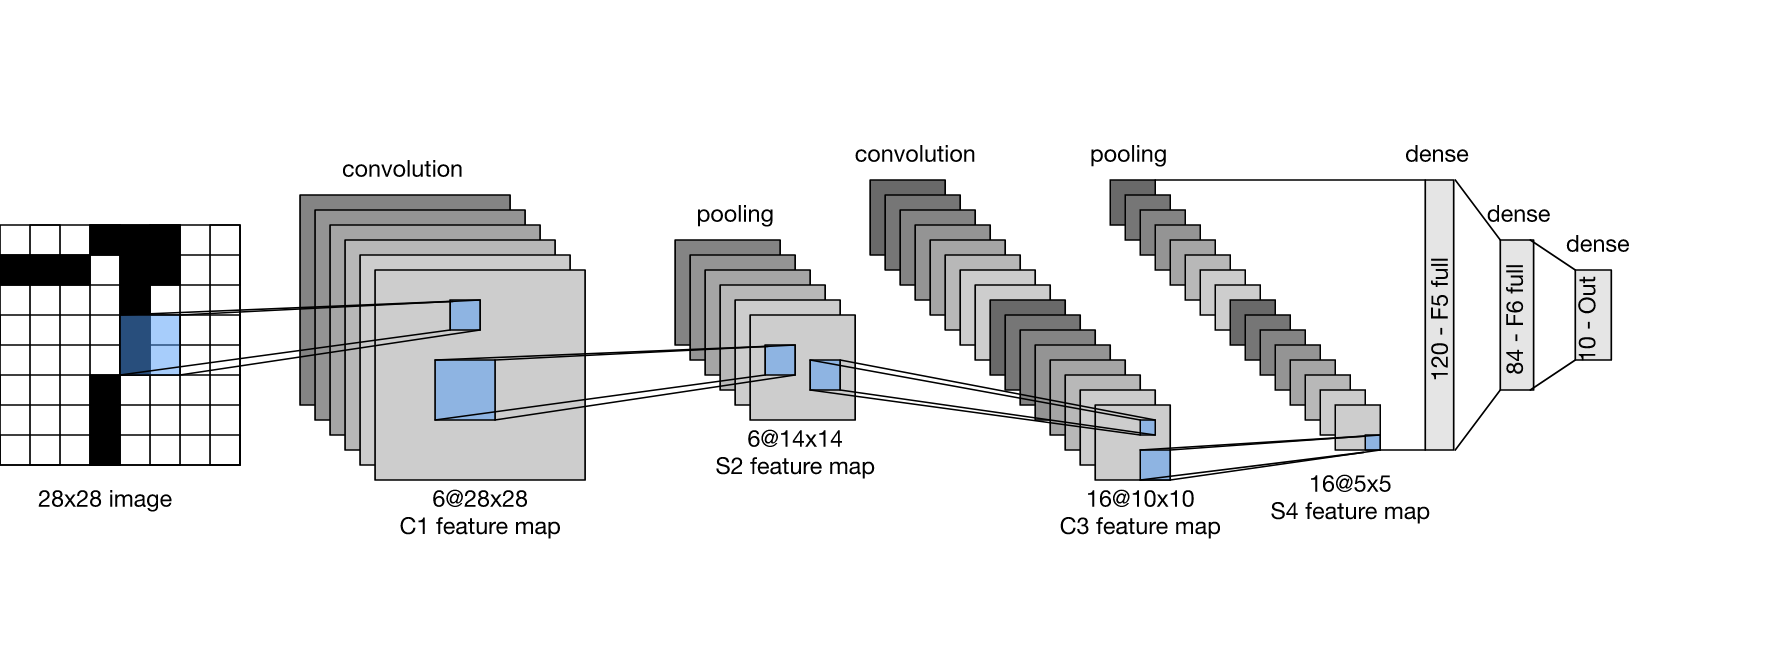

In [6]:
class LeNet(Classifier):
    def __init__(self, lr=0.1, num_outputs=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(6, kernel_size=5, activation='sigmoid', padding='same'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(16, kernel_size=5, activation='sigmoid', padding='same'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='sigmoid'),
            tf.keras.layers.Dense(84, activation='sigmoid'),
            tf.keras.layers.Dense(num_outputs)
        ])
        
    def layer_summary(self, X_shape):
        X = tf.random.normal(X_shape)
        for layer in self.net.layers:
            X = layer(X)
            print(layer.__class__.__name__,  'output shape:\t', X.shape)


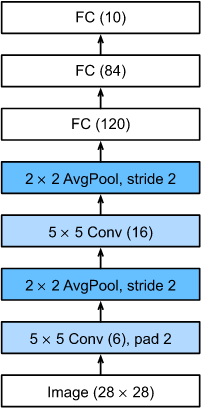# 

In [7]:
model = LeNet()
model.layer_summary((1,28,28,1))

2023-04-01 01:21:54.073797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204


Conv2D output shape:	 (1, 28, 28, 6)
AveragePooling2D output shape:	 (1, 14, 14, 6)
Conv2D output shape:	 (1, 14, 14, 16)
AveragePooling2D output shape:	 (1, 7, 7, 16)
Flatten output shape:	 (1, 784)
Dense output shape:	 (1, 120)
Dense output shape:	 (1, 84)
Dense output shape:	 (1, 10)


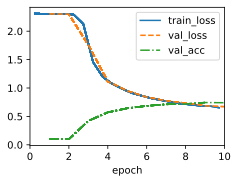

In [8]:
trainer = Trainer(max_epochs=10)
data = FashionMNIST(batch_size=128)
with try_gpu():
    model = LeNet()
    trainer.fit(model, data)